In [1]:
import os
import pandas as pd
import urllib.request
from grobid_quantities.quantities import QuantitiesClient
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

Download data:

In [3]:
PROJECT_ROOT_DIR = "."
DATA_NAME = "2022_JBR_Spring_Internship_Test_Data.csv"
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
DATA_FULL_PATH = os.path.join(DATA_PATH, DATA_NAME)
DOWNLOAD_URL = "https://drive.google.com/uc?export=download&id=1d3NJbq7EInZYl8Q5Pb7YfAwQUVxZ9FdE"


def fetch_data(url=DOWNLOAD_URL, path=DATA_PATH, data_full_path=DATA_FULL_PATH):
    os.makedirs(path, exist_ok=True)
    urllib.request.urlretrieve(url, data_full_path)


def load_data(data_path=DATA_FULL_PATH):
    return pd.read_csv(data_path)

In [4]:
fetch_data()
data = load_data()
data.head()

,PMID,abstract
0,35103873,It has been a challenge for solving the motor ...
1,35095410,The development of reliable assistive devices ...
2,35093844,Identifying motor and mental imagery electroen...
3,35090904,Brain computer interface (BCI) utilizes brain ...
4,35088740,Brain-computer interface (BCI)-controlled func...


Create a client for communication with grobid_quantities:

In [7]:
SERVER_URL = "http://localhost:8060/service/"

client = QuantitiesClient(apiBase=SERVER_URL)

We iterate over all the rows of the dataframe and parse the abstract:

In [70]:
values = []
accuracy = []

for index, row in tqdm(data.iterrows()):
    values_list = []
    accuracy_list = []

    try:
        result = client.process_text(row['abstract'].encode("ascii", "ignore"))
        if result[0] == 200:
            if 'measurements' in result[1]:
                for value_json in result[1]['measurements']:
                    if (value_json['type'] == 'value') and ('numeric' in value_json['quantity']['parsedValue']):
                        value = value_json['quantity']['parsedValue']['numeric']
                        values_list.append(value)

                        if ('quantified' in value_json) and (value_json['quantified']['normalizedName'] == 'accuracy'):
                            accuracy_list.append(value)
    except AttributeError:
        pass

    values.append(values_list)
    accuracy.extend(accuracy_list)

1429it [01:56, 12.24it/s]


List 'values' contains values for each of the paragraph and can be used further for our needs.
List 'accuracy' contains all the values, which grobid identifies as accuracies.

In [91]:
accuracy_np = np.array(accuracy)

The histogram of values >= 1 in log scale:

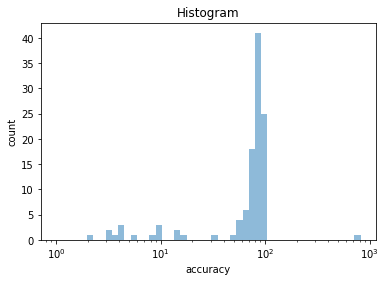

In [92]:
plt.hist(accuracy_np, bins = 10 ** np.linspace(np.log10(1), np.log10(np.max(accuracy_np)), 50), alpha=0.5)
plt.gca().set_xscale("log")
plt.title('Histogram')
plt.xlabel('accuracy')
plt.ylabel('count')
plt.show()

The histogram with not too low or too high values:

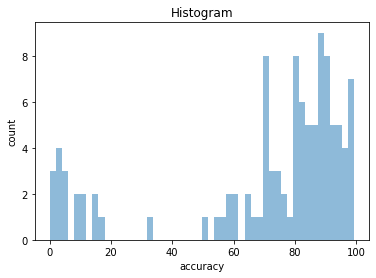

In [94]:
low_border = np.percentile(accuracy_np, 5)
high_border = np.percentile(accuracy_np, 95)

plt.hist(accuracy_np[(accuracy_np >= low_border) & (accuracy_np <= high_border)], bins = 50, alpha=0.5)
plt.title('Histogram')
plt.xlabel('accuracy')
plt.ylabel('count')
plt.show()